# Cybersecurity Threat ML Project

## Introduction

The aim of our cybersecurity project is to treat and analyse data from a wireshark recording so that we can identify threats. We tried to develop a model which can predict if a record contains a DoS attack.

We organized our team with a lead developper who assigned tasks and code to others. There was also an infrastructure leader. All the brainstorms were done together. 

Technically we divided the project into different files for the data cleaning, the data preparation and the predictions. We also designed our infrastructure with a dockerfile and a docker compose stack. When deployed in production the server runs fastAPI from `app.py`. We calculated some models' metrics that we saved on MlFlow. 

## Code

### `Download.py`

Firstly we imported kaggle. We defined a function to download the data from kaggle. We printed the path to the dataset during the execution.

In [ ]:
import kagglehub

def download_dataset() -> str:
    # Download latest version and return path of downloaded files
    return kagglehub.dataset_download("chethuhn/network-intrusion-dataset")


if __name__ == "__main__":
    print(f"Path to dataset: {download_dataset()}")

### `Clean.py`

Firstly we did some importations. We ensured that if the user didn't have the libraries he received a message saying that he must install it.

In [ ]:
import os
from download import download_dataset

try:
    import pandas as pd
except ImportError:
    print("You need to install pandas")
    exit()

try:
    import numpy as np
except ImportError:
    print("You need to install numpy")
    exit()

We defined a final variable which is the treshold of similarities percentage. The columns with a higher percentage of similarities are dropped.

Then we defined a function to calculate the percentage of column similarities. 

In [ ]:
COLUMN_SIMILARITY_THRESHOLD = 95

def get_percentage_columns_similarity(df):
    return (1 - (df.nunique() / len(df))) * 100

The next function allows to load and clean the data. First it concatenates all the csv files in the dataframe "global_df". It deletes the spaces thanks to the strip() function. It drops the columns according to the similarity threshold but keeping the labels. It also drops duplicates and all lines whose label is not "BENIGN" neither "DoS".

In [ ]:
def load_and_clean_data(data_path=download_dataset()):
    global_df = pd.DataFrame()
    for root, dirs, files in os.walk(data_path):
        for file in files:
            if file.endswith(".csv"):
                df = pd.read_csv(os.path.join(root, file))
                global_df = pd.concat([global_df, df], ignore_index=True)

    global_df.columns = global_df.columns.str.strip()

    # Drop columns according to similarity threshold
    columns_to_drop = get_percentage_columns_similarity(global_df)
    columns_to_drop = columns_to_drop[columns_to_drop > COLUMN_SIMILARITY_THRESHOLD].index
    # Don't drop the label column
    columns_to_drop = columns_to_drop.drop('Label')
    global_df = global_df.drop(columns=columns_to_drop)
    global_df = global_df.replace([float('-inf'), float('inf')], float('nan')).dropna()
    # drop duplicates
    global_df = global_df.drop_duplicates()
    # Drop all lines where the label is not BENIGN or does not contains "DoS"
    global_df = global_df[global_df['Label'].str.contains('DoS') | global_df['Label'].str.contains('BENIGN')]

    return global_df

Then we defined a function to save the features and the labels. It takes as parameters the dataframe cleaned as well as the features and labels paths. First it separates the label colum from the features. It makes the "BENIGN" labels become 0 and the others 1. Then it counts the number of labels for each types. Then it extracts the features and the labels from the dataframe. It creates a path for features and a path for labels in case of they don't already exist. It saves the features and the labels in csv files and it prints the paths.

In [ ]:
def save_features_and_labels(global_df, features_path='data/features.csv', labels_path='data/labels.csv'):
    # Separate label column from features
    global_df['Label'] = np.where(global_df['Label'].isin(['BENIGN']), 0, 1)
    print("Labels count : ", global_df['Label'].value_counts())
    labels = global_df['Label']
    features = global_df.drop(columns=['Label'])

    # Create features_path and labels_path's directory if it doesn't exist
    if not os.path.exists(os.path.dirname(features_path)):
        os.makedirs(os.path.dirname(features_path))
    if not os.path.exists(os.path.dirname(labels_path)):
        os.makedirs(os.path.dirname(labels_path))

    # Save to csv
    features.to_csv(features_path, index=False)
    labels.to_csv(labels_path, index=False)

    print(f"Features and labels saved to {features_path} and {labels_path}")

Finally during the execution we affected to the global_df variable the cleaned dataframe and we saved its features and labels.

In [ ]:
if __name__ == "__main__":
    global_df = load_and_clean_data()
    save_features_and_labels(global_df)

### `Preparation.py`

First we did some importations. Pandas allows dataframes manipulation, seaborn and matplotlib allow data visualization, numpy allows math calculations and array manipulation, and RandomUnderSampler allows undersampling.

We loaded the features and the labels in dataframes that we returned in the function load_data().

In [ ]:
def load_data(features_path, labels_path):
    features = pd.read_csv(os.path.abspath(features_path))
    labels = pd.read_csv(os.path.abspath(labels_path))
    return features, labels

Then we defined a function whose aim is to do and save a correlation matrix as an image. First we made a copy of the dataframe and we added a column with the labels. Then we calculated the correlation matrix. We plotted it making sure that the lowest values were in blue and the highest in red. We saved the image in a file.

In [ ]:
def save_correlation_matrix(df, labels, filename):
    features_with_labels = df.copy()
    features_with_labels['Label'] = labels
    corr = features_with_labels.corr()
    plt.figure(figsize=(20, 20))
    sns.heatmap(corr, annot=False, cmap='coolwarm')
    plt.savefig(filename)
    print(f"Correlation matrix saved to {filename}")

We defined a function that dropped the most correlated features. For that we defined a threshold. We created the upper triangle of the correlation matrix, we selected the colums with the correlations above threshold and we dropped them. 

In [ ]:
def clean_correlated_features(df, threshold=0.9):
    corr_matrix = df.corr().abs()
    # Create the upper triangle of the correlation matrix (no need to keep the lower triangle and diagonal)
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    # Select columns with correlations above threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]
    return df.drop(columns=to_drop)

Our data was unbalanced we decided to do some undersampling. We did it in the function resample_data(). We used the RandomUnderSampler() function which undersample the majority class. We applied the undersampling on our data and we saved it into new dataframes that we returned.

In [ ]:
def resample_data(features, labels):
    rus = RandomUnderSampler(random_state=17, sampling_strategy='majority')
    features_resampled, labels_resampled = rus.fit_resample(features, labels)
    return features_resampled, labels_resampled

We defined a function to save the data into csv files.

In [ ]:
def save_data(features, labels, features_path, labels_path):
    features.to_csv(features_path, index=False)
    labels.to_csv(labels_path, index=False)

During the execution we made some function calls. First we loaded the data, then we calculate and save the correlation matrix multiple times, after loading, after resample and after cleaning. Finally, we saved the data.

In [ ]:
if __name__ == "__main__":
    features, labels = load_data('data/features.csv', 'data/labels.csv')
    save_correlation_matrix(features, labels, 'data/corr_matrix.png')
    
    features_resampled, labels_resampled = resample_data(features, labels)
    save_correlation_matrix(features_resampled, labels_resampled, 'data/corr_matrix_resampled.png')

    features = clean_correlated_features(features)
    save_correlation_matrix(features, labels, 'data/corr_matrix_cleaned.png')
    
    save_data(features_resampled, labels_resampled, 'data/features_cleaned.csv', 'data/labels_cleaned.csv')

### `Prediction.py`

In this file we performed some training and testing of different models on data. 

We used python library sklearn.

The models are : 
- logistic regression
- random forest
- k-nn
- decision tree

We also calculated some metrics : 
- f1 score
- precision score
- recall score
- roc auc score

First we defined some global variables for training and evaluation.

In [ ]:
NUM_TRIALS = 5
NUM_FOLDS = 4
DEBUG = True
IS_PROD = True

Then we set the uri tracking and the experiment of MlFlow. This allows us to follow the model executions.

In [ ]:
mlflow.set_tracking_uri("https://mlflow.docsystem.xyz" if IS_PROD else "http://127.0.0.1:8080")
mlflow.set_experiment("RandomSearch")

We created 2 dataframes from the csv files of features and labels cleaned.

In [ ]:
features = pd.read_csv(os.path.abspath('data/features_cleaned.csv'))
labels = pd.read_csv(os.path.abspath('data/labels_cleaned.csv'))

We splitted the data for training (70%) and testing (30%).

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=25)

We reset the indexes of both train and test data in order to ensure some consistency.

In [ ]:
X_train = X_train.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

We added a label column to a copy of the test dataset.

In [ ]:
evalData = X_test.copy()
evalData['label'] = y_test

We defined a dictionary for the different models.

In [ ]:
models = {
    "Random Forest": RandomForestClassifier(),
    "Logistic Regression": LogisticRegression(max_iter=3000),
    "KNN": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(),
}

And we also defined a dictionary for the different models' parameters.

In [ ]:
param_distributions = {
    "Logistic Regression": {
        'C': np.logspace(-10, 10, 100),
    },
    "Random Forest": {
        'min_samples_split': np.arange(2, 21),
        'max_depth': np.arange(1, 21)
    },
    "KNN": {
        'n_neighbors': np.arange(1, 21),
        'p': np.arange(1, 6)
    },
    "Decision Tree": {
        'max_depth': np.arange(1, 21),
        'min_samples_split': np.arange(2, 21),
    }
}

We initialized some variables to store the best model, the best score and the best parameters.

In [ ]:
best_model = None
best_score = float('-inf')
best_params = None

Then we made a loop for training and testing each model. We tried to find the best hyperparameters. Then we same the actual model and its parameter distributions in local variables. 
Then we performed some scaling (except for the random foret model) with StandardScaler() and fit_transform() functions.

In [ ]:
for name in models.keys():
    print("Tuning hyperparameters for model", name)
    
    model = models[name]
    param_dist = param_distributions[name]
    
    if name != "Random Forest":
        # Scale data
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)
    else:
        X_train_scaled = X_train
        X_test_scaled = X_test

Still in the loop, we defined a function calculating the f1 score of real labels and predictions made by the estimator. 

In [ ]:
    def scoringfunc(estimator, X, y):
        return f1_score(y, estimator.predict(X))

We used the RandomizedSeachCV() function to find the best hyperparameters. Then we trained the model with those best parameters.

In [ ]:
    randomized_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=NUM_TRIALS,
        scoring=scoringfunc,
        cv=3,
        random_state=42,
        n_jobs=-1,
        verbose=3
    )
    
    randomized_search.fit(X_train_scaled, y_train.values.ravel())
    
    best = randomized_search.best_params_
    model.set_params(**best)
    model.fit(X_train_scaled, y_train.values.ravel())

Then we calculated the f1 score and obtained the signature of the model. Then we use this signature in the MlFlow recording and evaluation. MlFlow calculates the metrics and finds the best model based on the f1 score.

In [ ]:
    f1_test = f1_score(y_test, model.predict(X_test_scaled))
    
    signature = infer_signature(X_train_scaled, model.predict(X_train_scaled))
    
    with mlflow.start_run(run_name=name) as run:
        mlflow.log_params(best)
        mlflow.sklearn.log_model(model, "model", signature=signature)
        mlflow.log_metric("F1_Score", f1_test)
        mlflow.log_metric("Accuracy", model.score(X_test_scaled, y_test))
        mlflow.log_metric("Precision", precision_score(y_test, model.predict(X_test_scaled)))
        mlflow.log_metric("Recall", recall_score(y_test, model.predict(X_test_scaled)))
        mlflow.log_metric("AUC", roc_auc_score(y_test, model.predict_proba(X_test_scaled)[:, 1]))
        
        if f1_test > best_score:
            best_score = f1_test
            best_model = model
            best_params = best

Then we saved the best parameters and scores in a MlFlow experiment.

In [ ]:
mlflow.set_experiment("BestModelParams")
name = best_model.__class__.__name__
with mlflow.start_run(run_name=name) as run:
    mlflow.log_params(best_params)
    mlflow.log_metric("f1", best_score)

### `app.py`

We constructed an API thanks to FastAPI from fastapi library and BaseModel from pydantic library.

Then we configured the uri of the tracker server for MlFlow.

In [ ]:
mlflow.set_tracking_uri("https://mlflow.docsystem.xyz")

We loaded the model specifying an uri.

In [ ]:
model = mlflow.pyfunc.load_model(model_uri=f"models:/{model_name}/latest")

We set the two labels : "BENIGN" and "DDoS".

In [ ]:
LABELS_NUM = ['BENIGN', 'DDoS']

We set the column names mapping.

In [ ]:
COLUMN_MAPPINGS = {
    "flow_duration": "Flow Duration",
    "fwd_packet_length_std": "Fwd Packet Length Std",
    "bwd_packet_length_mean": "Bwd Packet Length Mean",
    "flow_bytes_s": "Flow Bytes/s",
    "flow_packets_s": "Flow Packets/s",
    "flow_iat_mean": "Flow IAT Mean",
    "flow_iat_std": "Flow IAT Std",
    "bwd_iat_total": "Bwd IAT Total",
    "bwd_iat_mean": "Bwd IAT Mean",
    "bwd_iat_std": "Bwd IAT Std",
    "bwd_iat_max": "Bwd IAT Max",
    "bwd_packets_s": "Bwd Packets/s",
    "active_mean": "Active Mean",
    "active_std": "Active Std",
    "active_max": "Active Max",
    "idle_std": "Idle Std"
}

We created an instance of FastAPI app.

In [ ]:
app = FastAPI()

We defined a function whose aim is to transform a dictionary into a dataframe, and another function whose aim to scale the dataframe.

In [ ]:
    def to_df(self):
        df = pd.DataFrame([self.dict()])
        # Change column labels
        for column in df.columns:
            df = df.rename(columns={column: COLUMN_MAPPINGS[column]})
        return df

    def scale_df(self):
        scaler = StandardScaler()
        return scaler.transform(self.to_df())

Finally we made a route FastAPI that returns the predictions of models.

In [ ]:
@app.post('/reports/')
async def create_report(report: Report):
    # Make predictions
    predictions = model.predict(report.scale_df())
    print(predictions)
    predictions = [LABELS_NUM[prediction] for prediction in predictions.tolist()]
    return {"predictions": predictions}

## Infrastructure

### Docker

We used docker as a container for our application. Technically, we made a dockerfile that creates a Docker image.

Here are the steps we followed : 

- We used specified the environment : python 3.09
- We defined the directory app in which we copied the content of the current directory. 
- We install some python dependencies. 
- We specified the port on which the app listens.
- We specified the default command.

In [ ]:
FROM python:3.9

WORKDIR /app

COPY . /app

RUN pip install --upgrade pip
RUN pip install -r requirements.txt

EXPOSE 8000

CMD ["/bin/sh", "-c", "/app/entrypoint.sh"]

We used docker compose tool in order to handle mulitple containers.

In [ ]:
services:
  backend:
    image: ghcr.io/ml-cyber-project/atdbackend:main
    networks:
      - reverseproxy
    restart: always
    labels:
      traefik.enable: true
      traefik.http.routers.atdbackend.rule: Host(`atdbackend.docsystem.xyz`)

networks:
  reverseproxy:
    external: true

### MlFlow

We used MlFLow for tracking the experiments and records the models' metrics,hyperparameters and other informations.

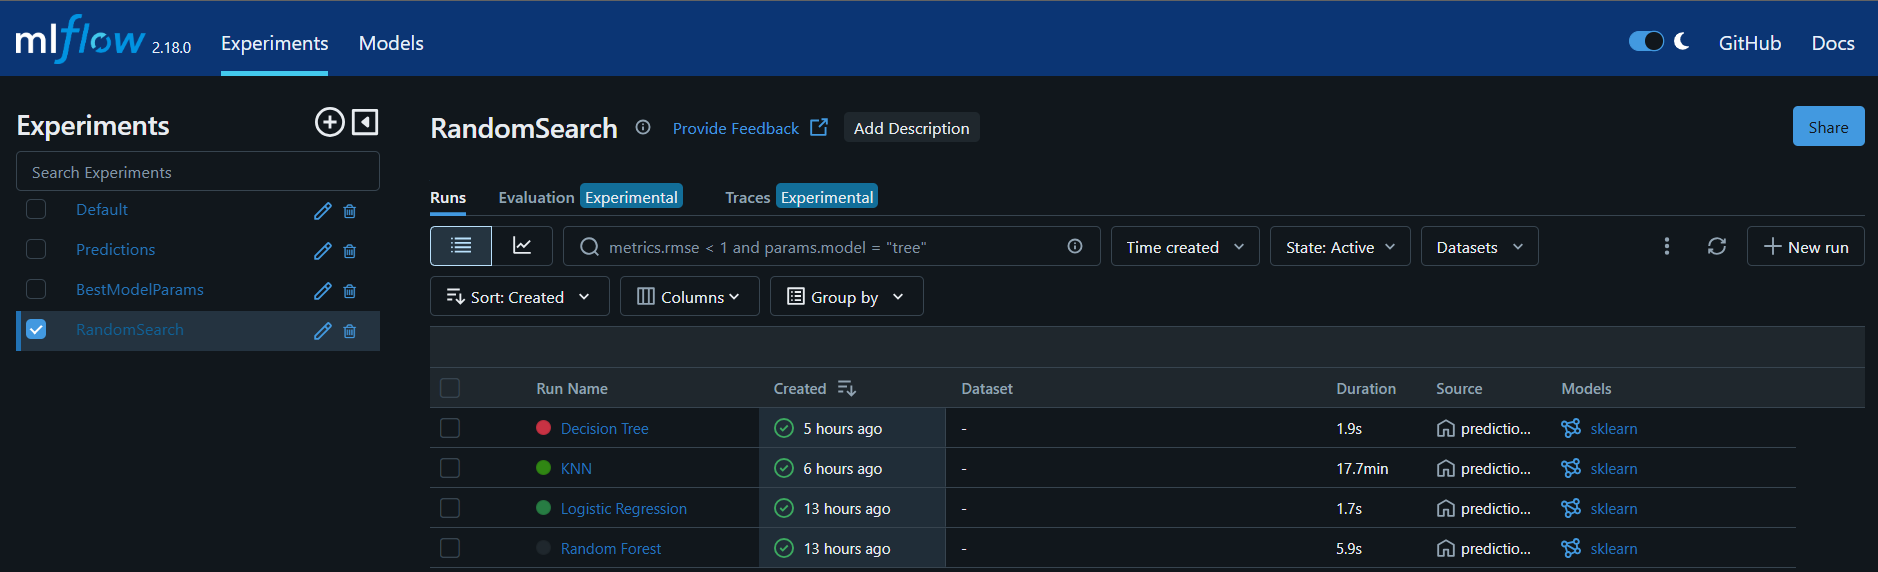

### CI/CD

## Conclusion

This project allowed us to apply all the course materials. We loaded a dataset that we cleaned and prepared. We performed some training and some testing. We calculated metrics and hyperparameters to find the best model. We used MlFlow in order to handle our experiments. We deployed our application in docker that we learned to use.